In [2]:
import sys
print(sys.executable)

sys.path.append('../../')

/home/mshunya/project/100_GQCO/GQCO/.env/bin/python3.11


In [3]:
import pickle
import time
import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
from torch_geometric.data import Batch
from IPython.display import display, Math
from qiskit import transpile, QuantumCircuit
from qiskit.quantum_info import Statevector, Operator

from gqco.train import MyModel
from gqco.utils import fix_seed, arange_token
from gqco.data import generate_data, RandomGraphDatasetWithClone
from gqco.solve import solve_from_token, plot_from_dict, brute_solver, probs_to_result
from gqco.model import TransformerWithMoE
from gqco.quantum import coef_to_pauli, pauli_to_matrix, make_cudaq_operator
from gqco.task import GQCO

import importlib
def fun_reload(pkg):
    module = importlib.import_module(pkg)
    module = importlib.reload(module)
    attrs = {attr: getattr(module, attr) for attr in dir(module)}
    globals().update(attrs)

fun_reload('gqco.solve')
fun_reload('gqco.quantum')
fun_reload('gqco.model')

### Setup

In [4]:
size_list = [3,4,5,6,7,8,9,10]

task_path = '../../model/taskobjects.pkl'
testdata_path = '../../data/testdata.pkl'

with open(task_path, 'rb') as f: 
    obj = pickle.load(f)
args = obj['args']
taskobj = GQCO(args)

with open(testdata_path, 'rb') as f:
    testdata = pickle.load(f)

In [5]:
def plot_from_dict(dict_pred, dict_true, savefile, is_legend=False, figsize=(5, 4)):

    dict_pred = {key: dict_pred[key] for key in dict_true if key in dict_pred}

    # Extract keys and values
    keys = list(dict_pred.keys())
    values_pred = list(dict_pred.values())
    values_true = list(dict_true.values())

    # Create the figure and the first axis
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Create a bar plot for dict A
    ax1.grid(axis='x', which='both', color='gray', alpha=0.5, linestyle='--', linewidth=0.5, zorder=0)
    ax1.bar(keys, values_pred, color=sns.color_palette('Blues', 24)[12], label="Machine's answer", alpha=1, zorder=2)
    ax1.set_xlabel('Keys', size=11)
    ax1.set_ylabel("Probability amplitude", size=11)
    ax1.tick_params(axis="y")

    
    # Create the second axis
    ax2 = ax1.twinx()
    
    # Create a scatter plot for dict B
    min_value = min(values_true)
    min_indices = [i for i, value in enumerate(values_true) if value == min_value]
    
    # Scatter plot with different color for the minimum value
    colors = [sns.color_palette('Blues', 24)[-1]] * len(values_true)
    for i in min_indices:
        colors[i] = 'tomato'  # Change color of the minimum value
    
    ax2.scatter(keys, values_true, color=colors, label='Exact value', zorder=3)
    ax2.set_ylabel('True cost', size=11)
    ax2.tick_params(axis='y')

    ax1.set_xlabel(None)

    
    # Show the plot
    if is_legend:
        fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.96), ncol=2)
    ax1.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    if savefile is not None:
        plt.savefig(f'{savefile}-probs.svg', bbox_inches='tight')
    plt.show()

Size: 3, ID: 412


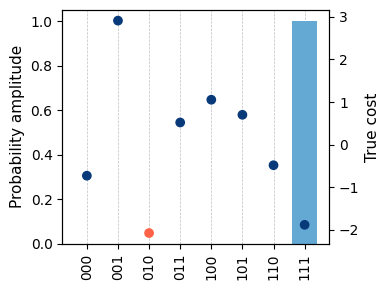

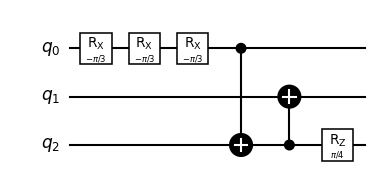

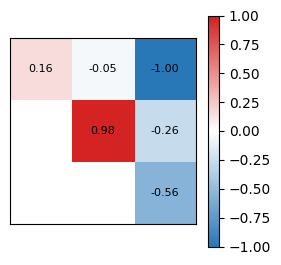

Size: 4, ID: 025


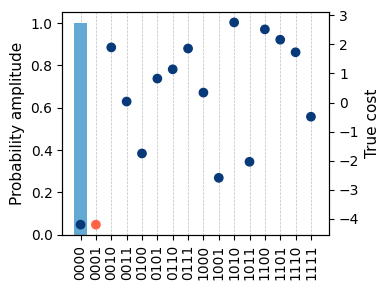

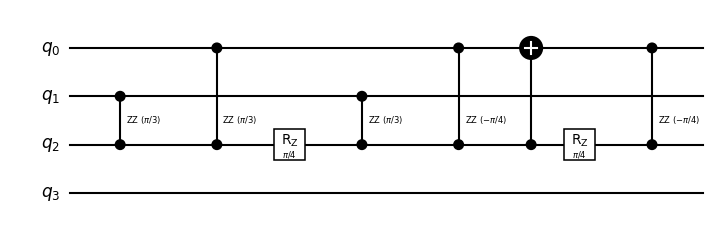

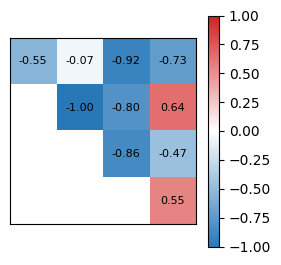

Size: 5, ID: 314


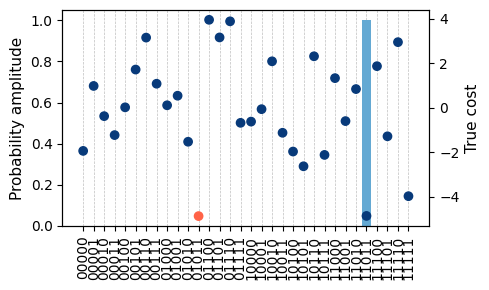

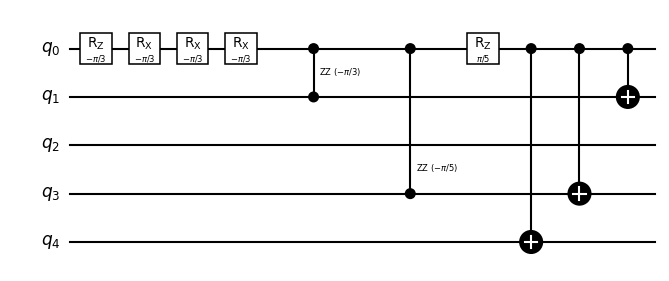

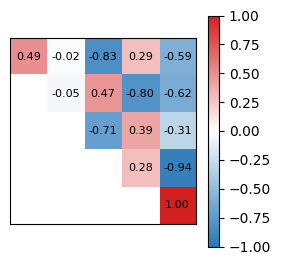

Size: 5, ID: 357


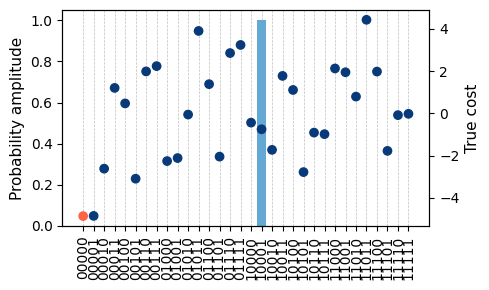

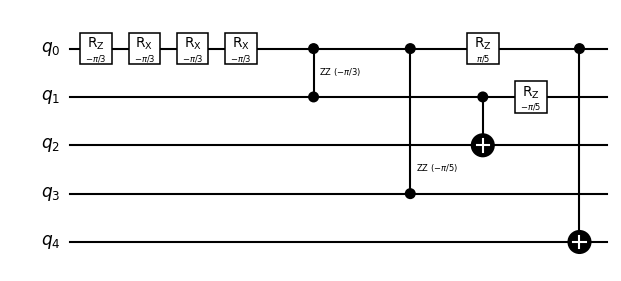

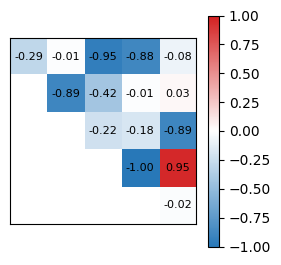

In [8]:
blue = sns.color_palette('Blues', 24)[17]
white = 'white'
red = sns.color_palette('Reds', 24)[17]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [blue, white, red])

for size in [3, 4, 5]:#size_list:
    with open(f'./outputs/pkl/gqcoans_s42_t2.0_cl100_s{size}.pkl', 'rb') as f:
        dct = pickle.load(f)
    
    for i, (ans, token) in enumerate(zip(dct['answer'], dct['tokens'])):
        if ans == 1:
            continue
    
        savename = f'./outputs/svg/400/400_size{size}-id{i:03}'
        print(f'Size: {size}, ID: {i:03}')
    
        ## For hard sample
        adj = testdata[size][i]
        dict_pred, dict_true, qc = solve_from_token(taskobj, token, adj, is_print=False, savefile=None)
        plot_from_dict(dict_pred, dict_true, savefile=savename, figsize=(max(size, 4), 3))
        
        display(qc.qc.draw(output='mpl', style='bw', scale=0.751, filename=f'./{savename}-circ.svg'))
    
        ## adj visualization
        mask = np.tril(np.ones_like(adj), -1)
        matrix = np.where(mask == 1, np.nan, adj)
        fig, ax = plt.subplots(figsize=(3,3))
        im = ax.imshow(matrix, cmap=cmap, vmin=-1, vmax=1)
        plt.colorbar(im)

        # Add values to the center of each box
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if not np.isnan(matrix[i, j]):  # Only add text to non-NaN values
                    ax.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)

        plt.xticks([])
        plt.yticks([])
        plt.savefig(f'./{savename}-adj.svg', bbox_inches='tight')
        plt.show()
    
        np.savetxt(f'./{savename}-adj.txt', adj.numpy(), fmt='%.5f')

## Typical circuit

In [109]:
def plot_from_dict(dict_pred, dict_true, savefile, is_legend=False, figsize=(5, 4), is_true=False):

    dict_pred = {key: dict_pred[key] for key in dict_true if key in dict_pred}

    # Extract keys and values
    keys = list(dict_pred.keys())
    values_pred = list(dict_pred.values())
    values_true = list(dict_true.values())

    # Create the figure and the first axis
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Create a bar plot for dict A
    ax1.grid(axis='x', which='both', color='gray', alpha=0.5, linestyle='--', linewidth=0.5, zorder=0)
    ax1.bar(keys, values_pred, color=sns.color_palette('Blues', 24)[12], label="Machine's answer", alpha=1, zorder=2)
    ax1.set_xlabel('Keys', size=11)
    ax1.set_ylabel("Probability amplitude", size=11)
    ax1.tick_params(axis="y")


    if is_true:
        # Create the second axis
        ax2 = ax1.twinx()
        
        # Create a scatter plot for dict B
        min_value = min(values_true)
        min_indices = [i for i, value in enumerate(values_true) if value == min_value]
        
        # Scatter plot with different color for the minimum value
        colors = [sns.color_palette('Blues', 24)[-1]] * len(values_true)
        for i in min_indices:
            colors[i] = 'tomato'  # Change color of the minimum value
        
        ax2.scatter(keys, values_true, color=colors, label='Exact value', zorder=3)
        ax2.set_ylabel('True cost', size=11)
        ax2.tick_params(axis='y')

    ax1.set_xlabel(None)

    
    # Show the plot
    if is_legend:
        fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.96), ncol=2)
    ax1.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    if savefile is not None:
        plt.savefig(f'{savefile}-probs.svg', bbox_inches='tight')
    plt.show()


Size: 3, ID: 001


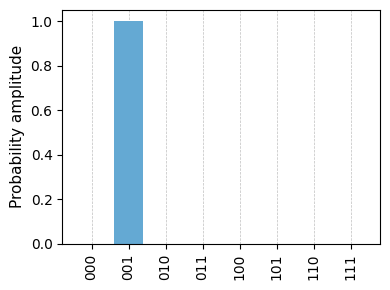

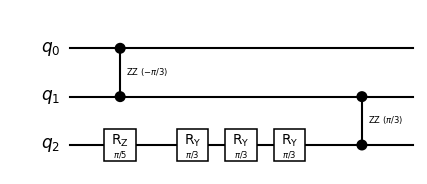

In [110]:
size = 3
with open(f'./outputs/pkl/gqcoans_s42_t2.0_cl100_s{size}.pkl', 'rb') as f:
    dct = pickle.load(f)

i = 1
ans = dct['answer'][i]
token = dct['tokens'][i]

savename = f'./outputs/svg/410/410_typical_circuit'
print(f'Size: {size}, ID: {i:03}')

## For hard sample
adj = testdata[size][i]
dict_pred, dict_true, qc = solve_from_token(taskobj, token, adj, is_print=False, savefile=None)
plot_from_dict(dict_pred, dict_true, savefile=f'./outputs/svg/410_typical_prob.svg', figsize=(max(size, 4), 3))

display(qc.qc.draw(output='mpl', style='bw', scale=0.751, filename=f'./outputs/svg/410_typical_circuit.svg'))